In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import preprocessing 


In [2]:
def classification_accuracy(train_data, predicted_clusters, test_data):
    actual_labels = test_data.value_counts().index.tolist()
    train_data['predicted_clusters'] = predicted_clusters
    cluster_labels = pd.value_counts(pd.Series(predicted_clusters))
    cluster_labels = np.stack([cluster_labels.keys().values, cluster_labels.values]).T
    cluster_labels = cluster_labels.tolist()
    for i in range(len(cluster_labels)):
        if i>=len(actual_labels):
            break
        cluster_labels[i].append(actual_labels[i])
    cluster_labels.sort()
    for i in cluster_labels:
        if len(i)<3:
            i.append(-1)
    for i in cluster_labels:
        if i[0]<0 :
            i.pop(2)
            i.append(-1)
    for i in cluster_labels:
        if len(i)<3:
            i.append(-1)
    train_data['predicted_labels'] = list(map(lambda x : cluster_labels[x+1][2], train_data['predicted_clusters']))
    sum(train_data['predicted_labels']==test_data)
    accuracy = sum(train_data['predicted_labels']==test_data)/len(train_data)
    print("Classification accuracy: ", accuracy)


# Wine dataset

In [3]:
# reading tsv files
wine_data = pd.read_csv('wine.csv')
wine_data.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
wine_df = wine_data.iloc[:, 1:14]
wine_label = wine_data.iloc[:,0]

In [5]:
# Preprocessing for features 
scaled_features_df = StandardScaler().fit_transform(wine_df.values)

In [6]:
# PCA data 
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_features_df)

In [7]:
# Processing of the labels
M = wine_label.to_numpy()
labels_true_wine = M

Begin Clustering on Scaled DF (Without PCA)

In [8]:
# Plotting the K-NN distplot - This helps to identify elbow point for epsilon values

# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=3).fit(scaled_features_df)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(scaled_features_df)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

2.625995204233969


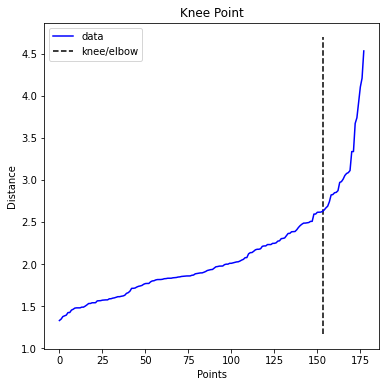

In [9]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
k_dist = sort_neigh_dist[:, 2]
i = np.arange(len(k_dist))
knee = KneeLocator(i, k_dist, S=1, curve='convex', direction='increasing', interp_method='polynomial')
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(k_dist[knee.knee])

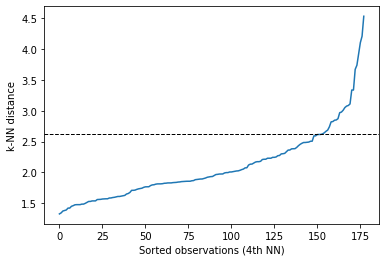

In [10]:
plt.plot(k_dist)
plt.axhline(y=2.625, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [11]:
clusters = DBSCAN(eps=2.625, min_samples=3).fit(scaled_features_df)
train_data = pd.DataFrame(scaled_features_df)
# get cluster labels
clusters.labels_

core_samples_mask = np.zeros_like(clusters.labels_, dtype=bool)
core_samples_mask[clusters.core_sample_indices_] = True
labels = clusters.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(labels)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true_wine, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true_wine, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true_wine, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true_wine, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true_wine, labels)
)
print("Silhouette Score: %0.3f" % metrics.silhouette_score(scaled_features_df, labels))

#silhouette (cohesion compared to separation, high value indicates well matched to its own cluster and poorly to 
#neighboring clusters)

#Davies-Bouldin Index (cluster overlap by measuring the ratio of the sum of within-cluster scatters to between-cluster 
#separations, low value indicates indicates that the clusters are compact and far)
print('Davies Bouldin score is: %0.3f' % metrics.davies_bouldin_score(scaled_features_df, labels))

#calinski harabasz score (Well-defined clusters have a large between-cluster variance and a small within-cluster variance,
#larger index value indicates optimal number of clusters)
print('Calinski Harabasz score is:  %0.3f' % metrics.calinski_harabasz_score(scaled_features_df, labels))


# Classification accuracy as well
test_data = pd.Series(labels_true_wine)
classification_accuracy(train_data, labels, test_data)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0 -1  0 -1
  0 -1  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  0 -1  0  0 -1  0  0  0  0
  0 -1 -1 -1 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]
Estimated number of clusters: 1
Estimated number of noise points: 19
Homogeneity: 0.068
Completeness: 0.216
V-measure: 0.103
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.096
Silhouette Score: 0.164
Davies Bouldin score is: 3.774
Calinski Harabasz score is:  5.429
Classification accuracy:  0.30337078651685395


Clustering on Scaled DFA with PCA 

In [12]:
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=3).fit(pca_data)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(pca_data)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

In [13]:
k_dist = sort_neigh_dist[:, 2]


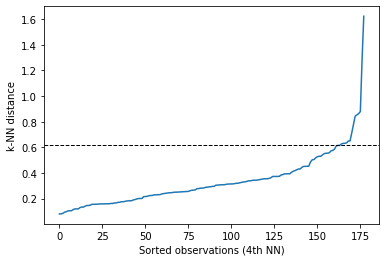

In [14]:
plt.plot(k_dist)
plt.axhline(y=0.617, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

0.5539732187671017


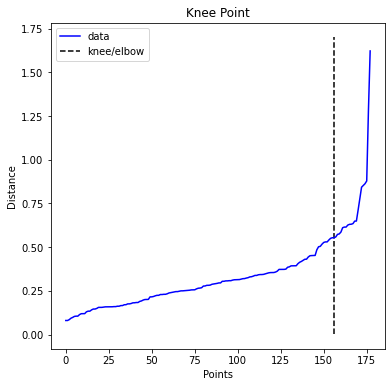

In [15]:
from kneed import KneeLocator
i = np.arange(len(k_dist))
knee = KneeLocator(i, k_dist, S=1, curve='convex', direction='increasing', interp_method='polynomial')
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(k_dist[knee.knee])

In [16]:
#clusters = DBSCAN(eps=0.617, min_samples=4).fit(pca_data)
clusters = DBSCAN(eps=0.554, min_samples=3).fit(pca_data)
train_data = pd.DataFrame(pca_data)

# get cluster labels
clusters.labels_

core_samples_mask = np.zeros_like(clusters.labels_, dtype=bool)
core_samples_mask[clusters.core_sample_indices_] = True
labels = clusters.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(labels)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true_wine, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true_wine, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true_wine, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true_wine, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true_wine, labels)
)

print("Silhouette Score: %0.3f" % metrics.silhouette_score(pca_data, labels))

#silhouette (cohesion compared to separation, high value indicates well matched to its own cluster and poorly to 
#neighboring clusters)

#Davies-Bouldin Index (cluster overlap by measuring the ratio of the sum of within-cluster scatters to between-cluster 
#separations, low value indicates indicates that the clusters are compact and far)
print('Davies Bouldin score is: %0.3f' % metrics.davies_bouldin_score(pca_data, labels))

#calinski harabasz score (Well-defined clusters have a large between-cluster variance and a small within-cluster variance,
#larger index value indicates optimal number of clusters)
print('Calinski Harabasz score is:  %0.3f' % metrics.calinski_harabasz_score(pca_data, labels))


test_data = pd.Series(labels_true_wine)
classification_accuracy(train_data, labels, test_data)

[ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0
  0  0 -1  0  0  0  0  0  0  0  0  1  1  1  0  0  1  0  0  1  2  0  1  0
  2  0  0  1  1  1  0  0 -1  0  1  3  0  1  1  1  1  1  1  1  1  1  1  0
  2  1  0  1  1  1  0  1  1  1  1  1  1  0  0  1  1  1  1 -1  1  1 -1  1
  0  0  1  2  0  1  0  1  1  1 -1  3  3  3  3  3  3  3  3  3  3  3  3  3
  4  3  3  3  3  3  3  3  4  3  3  3  3  3 -1 -1  3  4  3  3  3  3  3  3
  3  3 -1  3  3  3  3  3  3  3]
Estimated number of clusters: 5
Estimated number of noise points: 12
Homogeneity: 0.679
Completeness: 0.533
V-measure: 0.597
Adjusted Rand Index: 0.530
Adjusted Mutual Information: 0.587
Silhouette Score: 0.167
Davies Bouldin score is: 2.241
Calinski Harabasz score is:  83.089
Classification accuracy:  0.34831460674157305


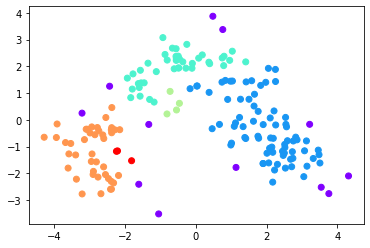

In [17]:
pca_data_df = pd.DataFrame(pca_data)
pca_data_df.columns = ['P1', 'P2']
plt.figure()
plt.scatter(pca_data_df['P1'], pca_data_df['P2'],
            c = labels, cmap ='rainbow')
plt.show()

# Start Yeast Dataset

In [74]:
#reading tsv files
column_names = ["Sequence Name", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "Correct classification"]
pd.options.display.float_format = '{:,.2f}'.format

yeast_df = pd.read_csv("yeast.data",  sep=r"\s{2,}", engine="python", names = column_names, on_bad_lines='skip')
yeast_df

,Sequence Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,Correct classification
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.50,0.00,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.50,0.00,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.50,0.00,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.50,0.00,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.50,0.00,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...,...,...
1479,YUR1_YEAST,0.81,0.62,0.43,0.17,0.50,0.00,0.53,0.22,ME2
1480,ZIP1_YEAST,0.47,0.43,0.61,0.40,0.50,0.00,0.48,0.47,NUC
1481,ZNRP_YEAST,0.67,0.57,0.36,0.19,0.50,0.00,0.56,0.22,ME2
1482,ZUO1_YEAST,0.43,0.40,0.60,0.16,0.50,0.00,0.53,0.39,NUC


In [75]:
yeast_label = yeast_df.iloc[:,9]

In [76]:
yeast_df3 = yeast_df.iloc[:, [0,9]]
yeast_df3.head()

,Sequence Name,Correct classification
0,ADT1_YEAST,MIT
1,ADT2_YEAST,MIT
2,ADT3_YEAST,MIT
3,AAR2_YEAST,NUC
4,AATM_YEAST,MIT


In [77]:
yeast_df = yeast_df.drop(yeast_df.columns[[0,9]],axis = 1)
yeast_df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.61,0.47,0.13,0.50,0.00,0.48,0.22
1,0.43,0.67,0.48,0.27,0.50,0.00,0.53,0.22
2,0.64,0.62,0.49,0.15,0.50,0.00,0.53,0.22
3,0.58,0.44,0.57,0.13,0.50,0.00,0.54,0.22
4,0.42,0.44,0.48,0.54,0.50,0.00,0.48,0.22


In [78]:
df_yeast = yeast_df
# df_yeast = yeast_df.iloc[:, 1:9]


In [79]:
# Preprocessing for features
scaled_features_df = StandardScaler().fit_transform(df_yeast.values)
scaled_features_df = pd.DataFrame(scaled_features_df, index=yeast_df.index, columns=yeast_df.columns)
scaled_features_df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.89,-0.35,-0.96,-0.10,-0.10,-0.34,-0.53
1,-0.51,1.37,-0.23,0.06,-0.10,-0.10,0.52,-0.53
2,1.02,0.97,-0.12,-0.81,-0.10,-0.10,0.52,-0.53
3,0.58,-0.48,0.81,-0.96,-0.10,-0.10,0.69,-0.53
4,-0.58,-0.48,-0.23,2.03,-0.10,-0.10,-0.34,-0.53


In [80]:
scaled_features_df = scaled_features_df
scaled_features_df

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.89,-0.35,-0.96,-0.10,-0.10,-0.34,-0.53
1,-0.51,1.37,-0.23,0.06,-0.10,-0.10,0.52,-0.53
2,1.02,0.97,-0.12,-0.81,-0.10,-0.10,0.52,-0.53
3,0.58,-0.48,0.81,-0.96,-0.10,-0.10,0.69,-0.53
4,-0.58,-0.48,-0.23,2.03,-0.10,-0.10,-0.34,-0.53
...,...,...,...,...,...,...,...,...
1479,2.26,0.97,-0.81,-0.67,-0.10,-0.10,0.52,-0.53
1480,-0.22,-0.56,1.27,1.01,-0.10,-0.10,-0.34,1.82
1481,1.24,0.57,-1.62,-0.52,-0.10,-0.10,1.04,-0.53
1482,-0.51,-0.81,1.15,-0.74,-0.10,-0.10,0.52,1.07


In [81]:
# PCA data preparation
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_features_df)

In [82]:
scaled_features_df = scaled_features_df.to_numpy()
scaled_features_df

array([[ 0.58198136,  0.88848148, -0.3466451 , ..., -0.0991314 ,
        -0.34417514, -0.5279193 ],
       [-0.51089067,  1.37281104, -0.23122636, ..., -0.0991314 ,
         0.52121948, -0.5279193 ],
       [ 1.01913017,  0.96920307, -0.11580762, ..., -0.0991314 ,
         0.52121948, -0.5279193 ],
       ...,
       [ 1.23770457,  0.5655951 , -1.61625127, ..., -0.0991314 ,
         1.04045625, -0.5279193 ],
       [-0.51089067, -0.80667199,  1.15379854, ..., -0.0991314 ,
         0.52121948,  1.06900494],
       [ 1.0919883 ,  0.32343032,  0.46128609, ..., -0.0991314 ,
         0.52121948, -0.5279193 ]])

Begin Clustering on Scaled DF (Without PCA)

In [83]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=4).fit(scaled_features_df)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(scaled_features_df)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

1.3870978459586059


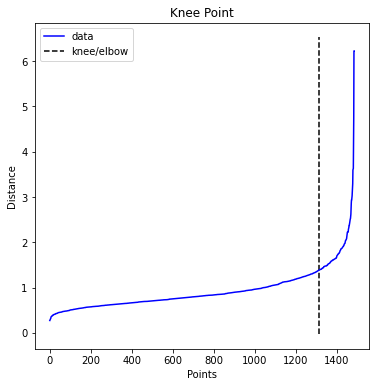

In [84]:
from kneed import KneeLocator
import matplotlib.pyplot as plt
k_dist = sort_neigh_dist[:, 3]
i = np.arange(len(k_dist))
knee = KneeLocator(i, k_dist, S=1, curve='convex', direction='increasing', interp_method='polynomial')
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(k_dist[knee.knee])

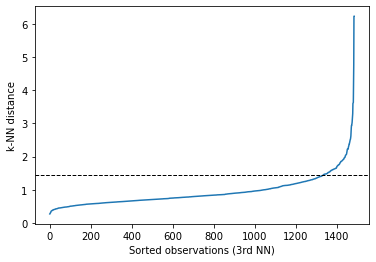

In [85]:
plt.plot(k_dist)
plt.axhline(y=1.44, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (3rd NN)")
plt.show()

In [86]:
clusters = DBSCAN(eps=1.38, min_samples=4).fit(scaled_features_df)
train_data = pd.DataFrame(scaled_features_df)

# get cluster labels
clusters.labels_

core_samples_mask = np.zeros_like(clusters.labels_, dtype=bool)
core_samples_mask[clusters.core_sample_indices_] = True
labels = clusters.labels_
print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(yeast_label, labels))
print("Completeness: %0.3f" % metrics.completeness_score(yeast_label, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(yeast_label, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(yeast_label, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(yeast_label, labels)
)
#silhouette (cohesion compared to separation, high value indicates well matched to its own cluster and poorly to 
#neighboring clusters)
print("Silhouette Score: %0.3f" % metrics.silhouette_score(df_yeast, labels))

#Davies-Bouldin Index (cluster overlap by measuring the ratio of the sum of within-cluster scatters to between-cluster 
#separations, low value indicates indicates that the clusters are compact and far)
print('Davies Bouldin score is: %0.3f' % metrics.davies_bouldin_score(df_yeast, labels))

#calinski harabasz score (Well-defined clusters have a large between-cluster variance and a small within-cluster variance,
#larger index value indicates optimal number of clusters)
print('Calinski Harabasz score is:  %0.3f' % metrics.calinski_harabasz_score(df_yeast, labels))

test_data = pd.Series(yeast_label)
classification_accuracy(train_data, labels, test_data)

[0 0 0 ... 0 0 0]
Estimated number of clusters: 3
Estimated number of noise points: 109
Homogeneity: 0.021
Completeness: 0.117
V-measure: 0.035
Adjusted Rand Index: 0.017
Adjusted Mutual Information: 0.028
Silhouette Score: 0.164
Davies Bouldin score is: 2.917
Calinski Harabasz score is:  19.142
Classification accuracy:  0.29582210242587603


Clustering on Scaled DF with PCA 

In [87]:
# PCA considered
from sklearn.decomposition import PCA # import PCA

pca = PCA(n_components=2)
pca.fit(scaled_features_df)
dfd_yeast = pca.transform(scaled_features_df)
# pca.fit(df_yeast)
# dfd_yeast = pca.transform(df_yeast)

In [88]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 3 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=4).fit(dfd_yeast)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(dfd_yeast)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

0.2516186446814561


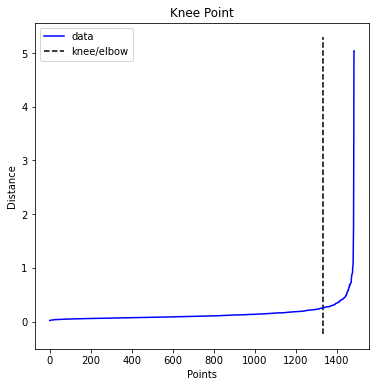

In [89]:
import matplotlib.pyplot as plt
from kneed import KneeLocator

k_dist = sort_neigh_dist[:, 3]
i = np.arange(len(k_dist))
knee = KneeLocator(i, k_dist, S=1, curve='convex', direction='increasing', interp_method='polynomial')
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(k_dist[knee.knee])


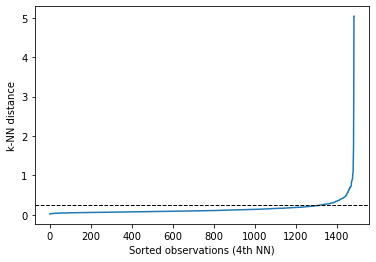

In [90]:
plt.plot(k_dist)
plt.axhline(y=0.25, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [91]:
# Optimal is 0.25

#clusters = DBSCAN(eps=0.055, min_samples=4).fit(dfd_yeast)
# clusters = DBSCAN(eps=0.02, min_samples=4).fit(dfd_yeast)
clusters = DBSCAN(eps=0.25, min_samples=4).fit(dfd_yeast)
train_data = pd.DataFrame(dfd_yeast)

# get cluster labels
clusters.labels_

core_samples_mask = np.zeros_like(clusters.labels_, dtype=bool)
core_samples_mask[clusters.core_sample_indices_] = True
labels = clusters.labels_
print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(yeast_label, labels))
print("Completeness: %0.3f" % metrics.completeness_score(yeast_label, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(yeast_label, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(yeast_label, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(yeast_label, labels)
)

print("Silhouette Score: %0.3f" % metrics.silhouette_score(dfd_yeast, labels))

#silhouette (cohesion compared to separation, high value indicates well matched to its own cluster and poorly to 
#neighboring clusters)

#Davies-Bouldin Index (cluster overlap by measuring the ratio of the sum of within-cluster scatters to between-cluster 
#separations, low value indicates indicates that the clusters are compact and far)
print('Davies Bouldin score is: %0.3f' % metrics.davies_bouldin_score(dfd_yeast, labels))

#calinski harabasz score (Well-defined clusters have a large between-cluster variance and a small within-cluster variance,
#larger index value indicates optimal number of clusters)
print('Calinski Harabasz score is:  %0.3f' % metrics.calinski_harabasz_score(dfd_yeast, labels))


test_data = pd.Series(yeast_label)
classification_accuracy(train_data, labels, test_data)

[0 0 0 ... 0 0 0]
Estimated number of clusters: 8
Estimated number of noise points: 111
Homogeneity: 0.036
Completeness: 0.148
V-measure: 0.058
Adjusted Rand Index: 0.022
Adjusted Mutual Information: 0.042
Silhouette Score: -0.047
Davies Bouldin score is: 1.889
Calinski Harabasz score is:  20.134
Classification accuracy:  0.28706199460916443


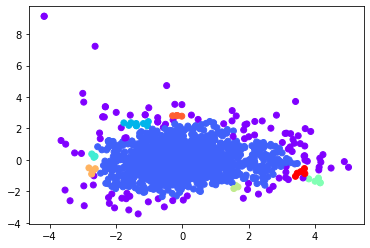

In [92]:
dfd_yeast_df = pd.DataFrame(dfd_yeast)
dfd_yeast_df.columns = ['P1', 'P2']
plt.figure()
plt.scatter(dfd_yeast_df['P1'], dfd_yeast_df['P2'],
            c = labels, cmap ='rainbow')
plt.show()

# Segemented Dataset

In [40]:
from sklearn import preprocessing 

cust_df = pd.read_csv('segmented_customers.csv')

In [41]:
df_cust = cust_df.iloc[:, 1:5]
cust_label = cust_df.iloc[:,5]

In [42]:
label_encoder = preprocessing.LabelEncoder()
df_cust['Gender'] = label_encoder.fit_transform(df_cust['Gender'])
df2 = df_cust.iloc[:, [0]]
df2.head()

<ipython-input-42-861d5a490d18>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cust['Gender'] = label_encoder.fit_transform(df_cust['Gender'])


,Gender
0,1
1,1
2,0
3,0
4,0


In [43]:
df_cust = df_cust.drop(columns=['Gender'])
df_cust.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [44]:
# Preprocessing for features 
scaled_features_df = StandardScaler().fit_transform(df_cust.values)
scaled_features_df = pd.DataFrame(scaled_features_df, index=df_cust.index, columns=df_cust.columns)
scaled_features_df.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.42,-1.74,-0.43
1,-1.28,-1.74,1.20
2,-1.35,-1.70,-1.72
3,-1.14,-1.70,1.04
4,-0.56,-1.66,-0.40


In [45]:
scaled_features_df = scaled_features_df.join(df2)
scaled_features_df


,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.42,-1.74,-0.43,1
1,-1.28,-1.74,1.20,1
2,-1.35,-1.70,-1.72,0
3,-1.14,-1.70,1.04,0
4,-0.56,-1.66,-0.40,0
...,...,...,...,...
195,-0.28,2.27,1.12,0
196,0.44,2.50,-0.86,0
197,-0.49,2.50,0.92,1
198,-0.49,2.92,-1.25,1


In [46]:
# PCA data 
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_features_df)

# Processing of the labels
M = cust_label.to_numpy()
cust_true_label = M

In [47]:
scaled_features_df = scaled_features_df.to_numpy()

Begin Clustering on Scaled DF

In [48]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=5).fit(scaled_features_df)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(scaled_features_df)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

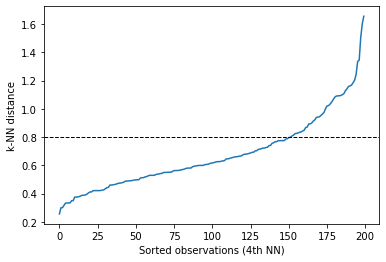

In [49]:
import matplotlib.pyplot as plt
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(y=0.8, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

0.9001885236266826


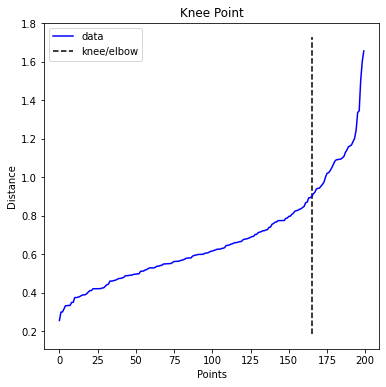

In [50]:
from kneed import KneeLocator
i = np.arange(len(k_dist))
knee = KneeLocator(i, k_dist, S=1, curve='convex', direction='increasing', interp_method='polynomial')
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(k_dist[knee.knee])

In [51]:
clusters = DBSCAN(eps=0.9, min_samples=5).fit(scaled_features_df)
# get cluster labels
clusters.labels_

core_samples_mask = np.zeros_like(clusters.labels_, dtype=bool)
core_samples_mask[clusters.core_sample_indices_] = True
labels = clusters.labels_
print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(cust_true_label, labels))
print("Completeness: %0.3f" % metrics.completeness_score(cust_true_label, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(cust_true_label, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(cust_true_label, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(cust_true_label, labels)
)

print("Silhouette Score: %0.3f" % metrics.silhouette_score(scaled_features_df, labels))

#silhouette (cohesion compared to separation, high value indicates well matched to its own cluster and poorly to 
#neighboring clusters)
#Davies-Bouldin Index (cluster overlap by measuring the ratio of the sum of within-cluster scatters to between-cluster 
#separations, low value indicates indicates that the clusters are compact and far)
print('Davies Bouldin score is: %0.3f' % metrics.davies_bouldin_score(scaled_features_df, labels))

#calinski harabasz score (Well-defined clusters have a large between-cluster variance and a small within-cluster variance,
#larger index value indicates optimal number of clusters)

print('Calinski Harabasz score is:  %0.3f' % metrics.calinski_harabasz_score(scaled_features_df, labels))

# Classification accuracy as well
#classification_accuracy(labels, cust_true_label)

[-1  0 -1  1  1  1  1  1 -1  1 -1  1  1  1 -1  0  1  0  0  1 -1  0  1  0
  1  0  1  0  1  1 -1  1 -1  0  1  1  1  1  1  1  1  0  0  1  1  1  1  1
  1  1  1  0  1  0  1  0  1  0  1  0  0  0  1  1  0  0  1  1  0  1  0  1
  1  1  0  0  1  0  1  1  0  0  0  1  1  0  1  1  1  1  1  0  0  1  1  0
  1  1  0  0  1  1  0  0  0  1  1  0  0  0  0  1  1  0  1  1  1  1  1  1
  0  1  1  0  1  1  0  0  0  0  0  0  1  1  0  1  1  0  0  1  1  0  1  1
  0  0  0  1  1  0  0  0  1  1  1  1  0  1  0  1  1  1  0  1  0  1  0  1
  1  0  0  0  0  0  1  1  0  0  0  0  1  1  0  1  1  0  1  0  1  1  1  1
 -1  1  1  1 -1 -1 -1 -1]
Estimated number of clusters: 2
Estimated number of noise points: 13
Homogeneity: 0.062
Completeness: 0.105
V-measure: 0.078
Adjusted Rand Index: 0.032
Adjusted Mutual Information: 0.060
Silhouette Score: 0.100
Davies Bouldin score is: 3.633
Calinski Harabasz score is:  10.402


Clustering of Scaled DF with PCA

In [52]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=5).fit(pca_data)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(pca_data)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

0.5195276774782354


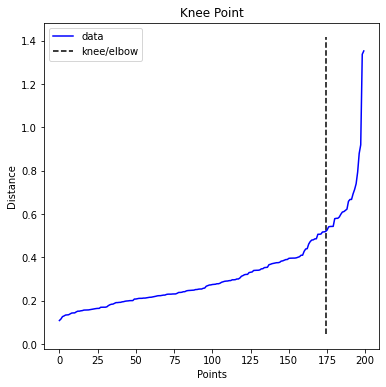

In [53]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
k_dist = sort_neigh_dist[:, 4]
i = np.arange(len(k_dist))
knee = KneeLocator(i, k_dist, S=1, curve='convex', direction='increasing', interp_method='polynomial')
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(k_dist[knee.knee])


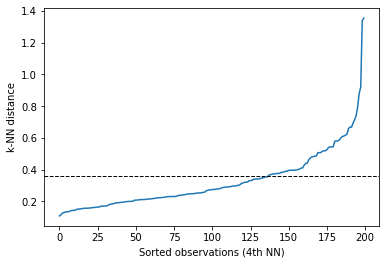

In [54]:

plt.plot(k_dist)
plt.axhline(y=0.36, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [55]:
# 0.519 seems to be unable to classify the data as seen below

In [56]:
clusters = DBSCAN(eps=0.519, min_samples=5).fit(pca_data)
# get cluster labels
clusters.labels_

core_samples_mask = np.zeros_like(clusters.labels_, dtype=bool)
core_samples_mask[clusters.core_sample_indices_] = True
labels = clusters.labels_
print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(cust_true_label, labels))
print("Completeness: %0.3f" % metrics.completeness_score(cust_true_label, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(cust_true_label, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(cust_true_label, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(cust_true_label, labels)
)

print("Silhouette Score: %0.3f" % metrics.silhouette_score(pca_data, labels))

#silhouette (cohesion compared to separation, high value indicates well matched to its own cluster and poorly to 
#neighboring clusters)
#Davies-Bouldin Index (cluster overlap by measuring the ratio of the sum of within-cluster scatters to between-cluster 
#separations, low value indicates indicates that the clusters are compact and far)
print('Davies Bouldin score is: %0.3f' % metrics.davies_bouldin_score(pca_data, labels))

#calinski harabasz score (Well-defined clusters have a large between-cluster variance and a small within-cluster variance,
#larger index value indicates optimal number of clusters)

print('Calinski Harabasz score is:  %0.3f' % metrics.calinski_harabasz_score(pca_data, labels))


[ 0  0  0  0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0
 -1  0 -1  0 -1 -1 -1 -1]
Estimated number of clusters: 1
Estimated number of noise points: 11
Homogeneity: 0.034
Completeness: 0.234
V-measure: 0.059
Adjusted Rand Index: 0.029
Adjusted Mutual Information: 0.046
Silhouette Score: 0.329
Davies Bouldin score is: 1.756
Calinski Harabasz score is:  14.793


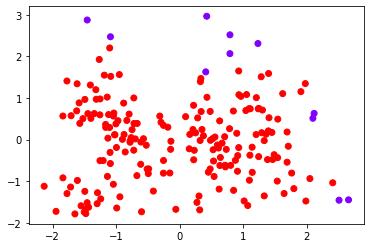

In [57]:
pca_data_df = pd.DataFrame(pca_data)
pca_data_df.columns = ['P1', 'P2']
plt.figure()
plt.scatter(pca_data_df['P1'], pca_data_df['P2'],
            c = labels, cmap ='rainbow')
plt.show()

In [58]:
# We do some manual tweaking 

In [59]:
# 0.36
clusters = DBSCAN(eps=0.36, min_samples=5).fit(pca_data)
# get cluster labels
clusters.labels_

core_samples_mask = np.zeros_like(clusters.labels_, dtype=bool)
core_samples_mask[clusters.core_sample_indices_] = True
labels = clusters.labels_
print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(cust_true_label, labels))
print("Completeness: %0.3f" % metrics.completeness_score(cust_true_label, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(cust_true_label, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(cust_true_label, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(cust_true_label, labels)
)

print("Silhouette Score: %0.3f" % metrics.silhouette_score(pca_data, labels))

#silhouette (cohesion compared to separation, high value indicates well matched to its own cluster and poorly to 
#neighboring clusters)
#Davies-Bouldin Index (cluster overlap by measuring the ratio of the sum of within-cluster scatters to between-cluster 
#separations, low value indicates indicates that the clusters are compact and far)
print('Davies Bouldin score is: %0.3f' % metrics.davies_bouldin_score(pca_data, labels))

#calinski harabasz score (Well-defined clusters have a large between-cluster variance and a small within-cluster variance,
#larger index value indicates optimal number of clusters)

print('Calinski Harabasz score is:  %0.3f' % metrics.calinski_harabasz_score(pca_data, labels))


[-1  0 -1  0 -1  0 -1  0 -1  0 -1  0  1  0 -1  0 -1  0 -1  0 -1  0  1  0
  1  0 -1 -1  2  0 -1  0  1 -1  1  0  2  0  2  0  2  0  2  3  2  3  2  3
  3  3  2  3  3  2  2  2  2  2  3  2  2  3  2  2  2  3  2  2  3  3  2  2
  2  2  2  3  2  2  3  2  2  2  2  2  3  2  2  3  3  2  2  3  2  2  2  3
  2  3  2  3  3  2  2  3  2  3  2  2  2  2  2  3  2  3  3  3  2  2  2  2
  3  2  2  3  2  3  2  3 -1  3  2  3  2  3  2  3  2  3  2  3 -1  3  2  3
  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3
  2  3  2  3  2  3 -1  3 -1  3 -1  3 -1  3 -1  3 -1 -1 -1 -1 -1  3 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]
Estimated number of clusters: 4
Estimated number of noise points: 36
Homogeneity: 0.489
Completeness: 0.535
V-measure: 0.511
Adjusted Rand Index: 0.344
Adjusted Mutual Information: 0.495
Silhouette Score: 0.256
Davies Bouldin score is: 2.683
Calinski Harabasz score is:  49.576


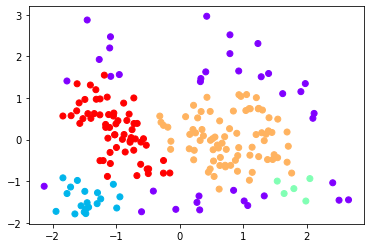

In [60]:
pca_data_df = pd.DataFrame(pca_data)
pca_data_df.columns = ['P1', 'P2']
plt.figure()
plt.scatter(pca_data_df['P1'], pca_data_df['P2'],
            c = labels, cmap ='rainbow')
plt.show()

# SONAR dataset

In [62]:
column_names = list(range(1,62))
pd.options.display.float_format = '{:,.4f}'.format

df = pd.read_csv("sonar.all-data", names = column_names, on_bad_lines='skip') 
df.head()

,1,2,3,4,5,6,7,8,9,10,...,52,53,54,55,56,57,58,59,60,61
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [63]:
sonar_label = df[61].values.tolist()
sonar_df = df.drop(columns = df.columns[-1])

# Preprocess
scaled_features_df = StandardScaler().fit_transform(sonar_df.values)

pca = PCA(n_components = 2)
pca_data = pca.fit_transform(scaled_features_df)

# Processing of the labels
# M = sonar_label.values.tolist()
# sonar_label = M

Begin Clustering on Scaled DF

In [64]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=4).fit(scaled_features_df)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(scaled_features_df)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

8.482121790248659


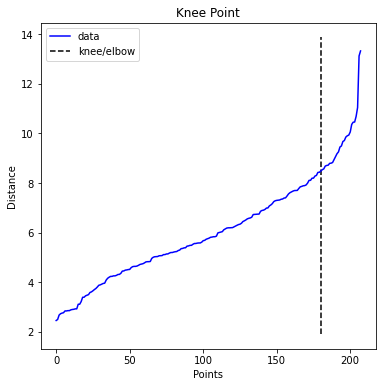

In [65]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
k_dist = sort_neigh_dist[:, 3]
i = np.arange(len(k_dist))
knee = KneeLocator(i, k_dist, S=1, curve='convex', direction='increasing', interp_method='polynomial')
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(k_dist[knee.knee])


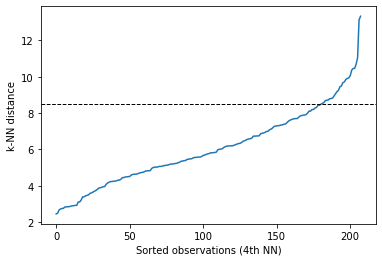

In [66]:
plt.plot(k_dist)
plt.axhline(y=8.48, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [67]:
clusters = DBSCAN(eps=8.48, min_samples=4).fit(scaled_features_df)
train_data = pd.DataFrame(scaled_features_df)
# get cluster labels
clusters.labels_

core_samples_mask = np.zeros_like(clusters.labels_, dtype=bool)
core_samples_mask[clusters.core_sample_indices_] = True
labels = clusters.labels_
print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(sonar_label, labels))
print("Completeness: %0.3f" % metrics.completeness_score(sonar_label, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(sonar_label, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(sonar_label, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(sonar_label, labels)
)

print("Silhouette Score: %0.3f" % metrics.silhouette_score(scaled_features_df, labels))

#silhouette (cohesion compared to separation, high value indicates well matched to its own cluster and poorly to 
#neighboring clusters)
#Davies-Bouldin Index (cluster overlap by measuring the ratio of the sum of within-cluster scatters to between-cluster 
#separations, low value indicates indicates that the clusters are compact and far)
print('Davies Bouldin score is: %0.3f' % metrics.davies_bouldin_score(scaled_features_df, labels))

#calinski harabasz score (Well-defined clusters have a large between-cluster variance and a small within-cluster variance,
#larger index value indicates optimal number of clusters)

print('Calinski Harabasz score is:  %0.3f' % metrics.calinski_harabasz_score(scaled_features_df, labels))

# Classification accuracy as well
test_data = pd.Series(sonar_label)
classification_accuracy(train_data, labels, test_data)

[ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0
  0 -1 -1  0  0 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  1 -1  1  1  1  0 -1  0 -1 -1 -1 -1
 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Estimated number of clusters: 2
Estimated number of noise points: 19
Homogeneity: 0.036
Completeness: 0.060
V-measure: 0.045
Adjusted Rand Index: -0.004
Adjusted Mutual Information: 0.036
Silhouette Score: 0.277
Davies Bouldin score is: 2.005
Calinski Harabasz score is:  15.248
Classification accuracy:  0.4423076923076923


In [68]:
# With PCA

In [69]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=4).fit(pca_data)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(pca_data)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

1.4131866453223612


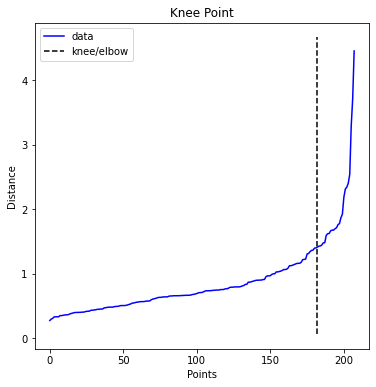

In [70]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
k_dist = sort_neigh_dist[:, 3]
i = np.arange(len(k_dist))
knee = KneeLocator(i, k_dist, S=1, curve='convex', direction='increasing', interp_method='polynomial')
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(k_dist[knee.knee])


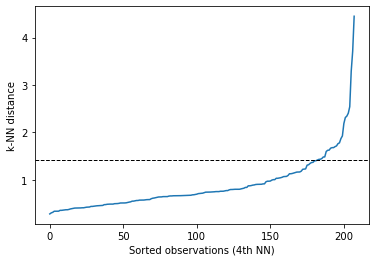

In [71]:
plt.plot(k_dist)
plt.axhline(y=1.41, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [72]:
clusters = DBSCAN(eps=1.41, min_samples=4).fit(pca_data)
train_data = pd.DataFrame(pca_data)
# get cluster labels
clusters.labels_

core_samples_mask = np.zeros_like(clusters.labels_, dtype=bool)
core_samples_mask[clusters.core_sample_indices_] = True
labels = clusters.labels_
print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(sonar_label, labels))
print("Completeness: %0.3f" % metrics.completeness_score(sonar_label, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(sonar_label, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(sonar_label, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(sonar_label, labels)
)

print("Silhouette Score: %0.3f" % metrics.silhouette_score(scaled_features_df, labels))

#silhouette (cohesion compared to separation, high value indicates well matched to its own cluster and poorly to 
#neighboring clusters)
#Davies-Bouldin Index (cluster overlap by measuring the ratio of the sum of within-cluster scatters to between-cluster 
#separations, low value indicates indicates that the clusters are compact and far)
print('Davies Bouldin score is: %0.3f' % metrics.davies_bouldin_score(scaled_features_df, labels))

#calinski harabasz score (Well-defined clusters have a large between-cluster variance and a small within-cluster variance,
#larger index value indicates optimal number of clusters)

print('Calinski Harabasz score is:  %0.3f' % metrics.calinski_harabasz_score(scaled_features_df, labels))

# Classification accuracy as well
test_data = pd.Series(sonar_label)
classification_accuracy(train_data, labels, test_data)

[ 0  1 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  1  0  0 -1  0
  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
  0 -1 -1  0  1  1  1  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  1  1  1  1  2 -1  2 -1  2  2  0 -1  0 -1 -1 -1  0
  0 -1 -1  2  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Estimated number of clusters: 3
Estimated number of noise points: 16
Homogeneity: 0.043
Completeness: 0.049
V-measure: 0.046
Adjusted Rand Index: -0.003
Adjusted Mutual Information: 0.034
Silhouette Score: 0.189
Davies Bouldin score is: 2.217
Calinski Harabasz score is:  13.964
Classification accuracy:  0.40865384615384615


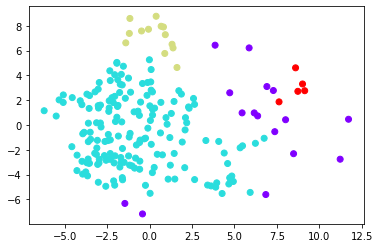

In [73]:
pca_data_df = pd.DataFrame(pca_data)
pca_data_df.columns = ['P1', 'P2']
plt.figure()
plt.scatter(pca_data_df['P1'], pca_data_df['P2'],
            c = labels, cmap ='rainbow')
plt.show()